## Session 03, task E

In this task you will use colour information to cluster images into classes based on similarity of mean colour value.

There are 6 classes of blobs, each of them has different value of hue.

This task is closely based on a Scikit-learn tutorial of k-means clustering

Let's start by loading data. You can observe how result change with different amount of examples and size of noise in the image.

,class,raw_data
count,30,30
unique,6,30
top,3,"[[[5, 5, 9], [20, 8, 5], [13, 13, 11], [10, 6,..."
freq,8,1


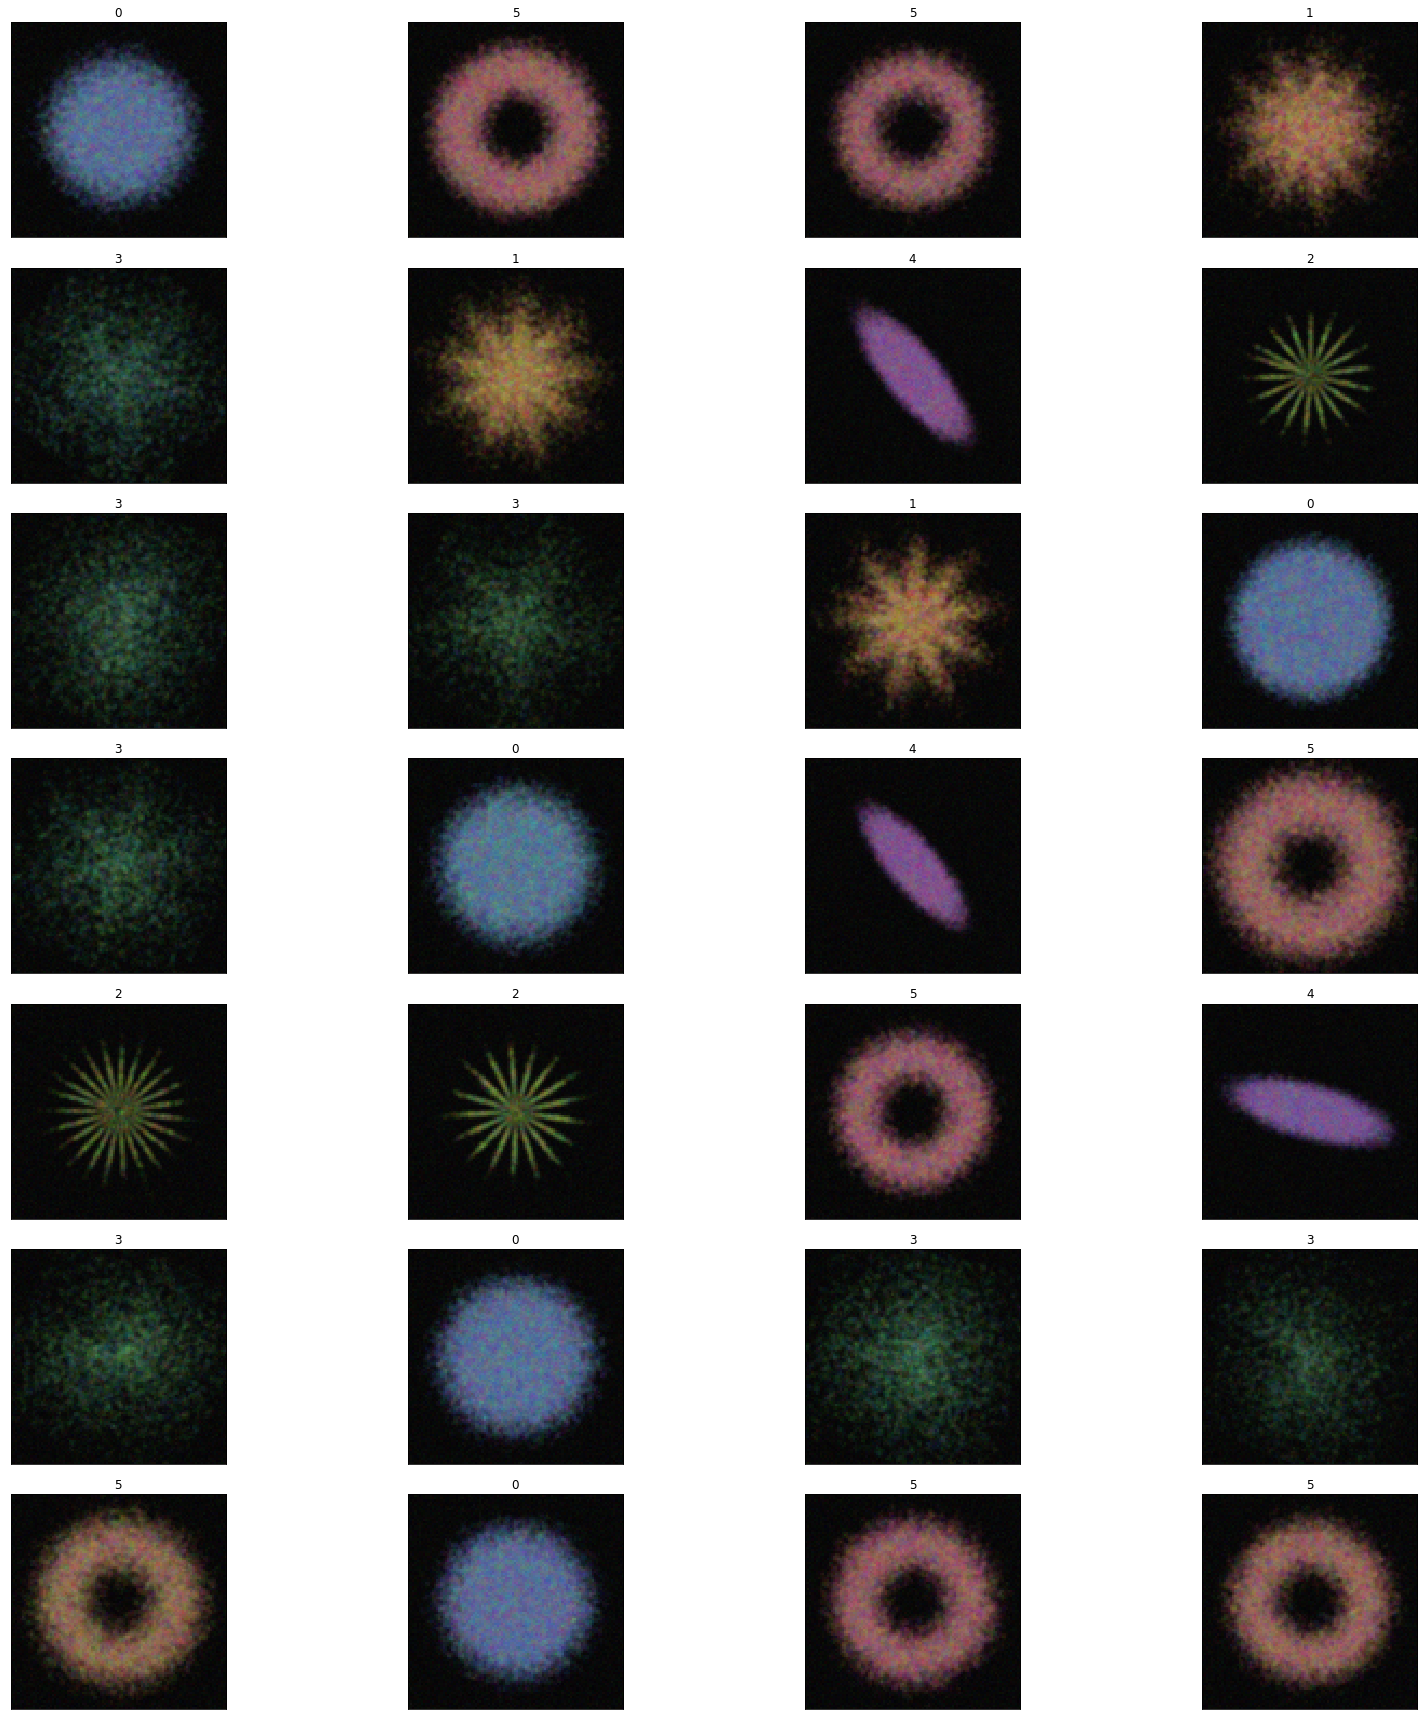

In [53]:
import pandas as pd
import numpy as np

#This function provides some data as a Pandas dataframe
from utils.practice_data import generateBlobsData
from utils.practice_data import showBlobs

imageDir = './assets/simple_blobs/'
# Is 30 a sufficent number of samples? How much noise can our algorithms deal with?
number_of_samples = 30
noise = 10 #value from 0 to 250
problem = generateBlobsData(imageDir, 6, 30, imSize = 100, colour=True, noiseSize = noise)

display(problem.describe())
showBlobs(problem.head(30))

As usual the data needs to have right datatype requested by algorithms. We will extract mean value of each colour channel. 

How does result compare to `median()` value?

In [54]:

y=problem['class'].values.reshape(-1,1).flatten().astype(int)

ch1means = []
ch2means = []
ch3means = []
for index, row in problem.iterrows():
    ch1mean = row['raw_data'][:,:,0].mean()
    ch2mean = row['raw_data'][:,:,1].mean()
    ch3mean = row['raw_data'][:,:,2].mean()
    ch1means.append(ch1mean)
    ch2means.append(ch2mean)
    ch3means.append(ch3mean)
problem['ch1']=ch1means
problem['ch2']=ch2means
problem['ch3']=ch3means

problem.describe()

,ch1,ch2,ch3
count,30.000000,30.000000,30.000000
mean,32.674467,30.760140,30.502583
std,17.676158,11.263765,16.347025
min,13.534800,15.334000,11.027400
25%,15.964300,21.053400,18.331925
50%,29.643800,29.794450,24.600100
75%,46.458625,40.096625,38.380300
max,74.036500,50.108100,64.287000


Let's display our samples in 32 space of RGB colour values

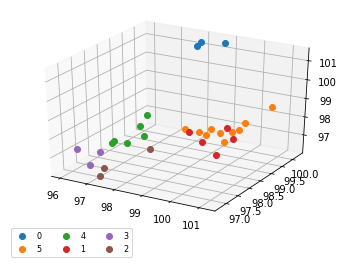

In [47]:
import matplotlib.pyplot as plt
%matplotlib inline
##display g
ax = plt.subplot(111, projection='3d')
blob_classes = problem['class'].unique()
for blob_class in blob_classes:
    ax.plot(problem[problem['class']==blob_class]['ch1'],
            problem[problem['class']==blob_class]['ch2'],
            problem[problem['class']==blob_class]['ch3'], 
            'o', label=blob_class)
    
plt.legend(loc='upper left', numpoints=1, ncol=3, fontsize=8, bbox_to_anchor=(0, 0))
plt.show()


K-means clustering

In [48]:
from sklearn import cluster
k_means = cluster.KMeans(n_clusters=6)
k_means.fit(problem[['ch1','ch2','ch3']]) 
problem['cluster'] = k_means.labels_

The simple way to estimate number of clusters from kmeans algorithm is to see a "knee" point in Sum of Square Errors (SSE) of samples.
You can access value of SSE using `.inertia_` attribute of a fitted kmeans model

In [49]:
# 1 Create a list to gather values for each cluster number candidates

# 2 Create a `for` loop in range of possible values
#    Calculate kmeans fit with a cluster number and add `.intertia_` parameter to the list

# 3 Plot values of SSE for each cluster

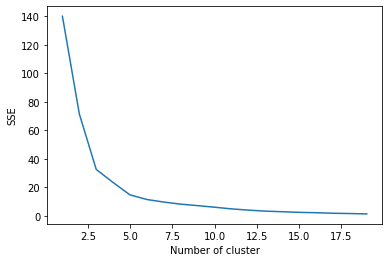

In [50]:
sse = {}
for k in range(1, 20):
    kmeans = cluster.KMeans(n_clusters=k, max_iter=5).fit(problem[['ch1','ch2','ch3']])
    #print(kmeans.inertia_)
    sse[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center
    
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.show()

Mean Shift Clustering: What happens if we change `bandwidth` parameter?

In [51]:
from sklearn.cluster import MeanShift
ms = MeanShift(bandwidth=10).fit(problem[['ch1','ch2','ch3']])
problem['cluster_ms'] = ms.labels_

Let's compare kmeans and Mean Shift clustering with ground-truth data

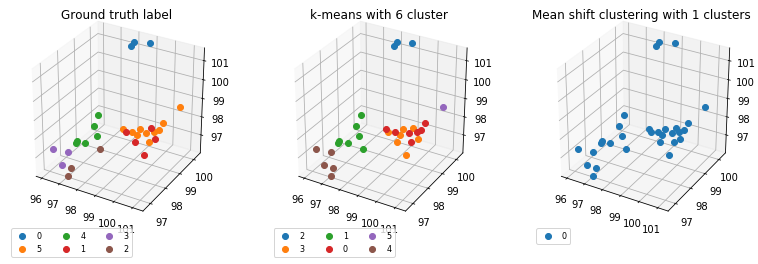

In [52]:
#show cluster
fig = plt.figure(figsize=plt.figaspect(0.3))
ax1 = fig.add_subplot(1, 3, 1, projection='3d')
ax2 = fig.add_subplot(1, 3, 2, projection='3d')
ax3 = fig.add_subplot(1, 3, 3, projection='3d')

blob_classes = problem['class'].unique()
for blob_class in blob_classes:
    ax1.plot(problem[problem['class']==blob_class]['ch1'],
            problem[problem['class']==blob_class]['ch2'],
            problem[problem['class']==blob_class]['ch3'], 
            'o', label=blob_class)
ax1.set_title('Ground truth label')    
blob_classes = problem['cluster'].unique()
for blob_class in blob_classes:
    ax2.plot(problem[problem['cluster']==blob_class]['ch1'],
            problem[problem['cluster']==blob_class]['ch2'],
            problem[problem['cluster']==blob_class]['ch3'], 
            'o', label=blob_class)
ax2.set_title('k-means with {} cluster'.format(len(blob_classes)))
    
blob_classes = problem['cluster_ms'].unique()
for blob_class in blob_classes:
    ax3.plot(problem[problem['cluster_ms']==blob_class]['ch1'],
            problem[problem['cluster_ms']==blob_class]['ch2'],
            problem[problem['cluster_ms']==blob_class]['ch3'], 
            'o', label=blob_class)
ax3.set_title('Mean shift clustering with {} clusters'.format(len(blob_classes)))    
    
ax1.legend(loc='upper left', numpoints=1, ncol=3, fontsize=8, bbox_to_anchor=(0, 0))
ax2.legend(loc='upper left', numpoints=1, ncol=3, fontsize=8, bbox_to_anchor=(0, 0))
ax3.legend(loc='upper left', numpoints=1, ncol=3, fontsize=8, bbox_to_anchor=(0, 0))

plt.show()